# Fig4. Global moisture budget conservation

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

import torch
from credit.boundary_padding import TensorPadding

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
import verif_utils as vu

In [2]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 1.5
#mpl.rcParams['hatch.linewidth'] = 1.0

### Load config

In [4]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

### Figure settings

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

## Data

In [6]:
# RMSE line graph
load_name = conf['data']['save_loc'] + 'Conservation_results.npy'
DATA = np.load(load_name, allow_pickle=True)[()]

In [7]:
start_date = datetime(2020, 1, 1)
xticks = [start_date + timedelta(hours=i) for i in range(0, 24*(365+366), 6)]

xticklabels = []
for dt in xticks:
    xticklabels.append(datetime.strftime(dt, '%Y-%m'))

## Plot

In [8]:
my_colors = gu.ksha_color_set_summon(color_set=0)
cyan = my_colors['cyan']
blue = my_colors['blue']
red = my_colors['red']
orange = my_colors['orange']

In [9]:
# line specs
line_keys = {}
line_keys['ERA5_025'] = {'linewidth': 3, 'linestyle': '-', 'color': cyan, 'alpha': 1, 'zorder': 2, 'label': ''}
line_keys['ERA5_1deg'] = {'linewidth': 3, 'linestyle': '-', 'color': '0.5', 'alpha': 1, 'zorder': 2, 'label': ''}
line_keys['fuxi_dry'] = {'linewidth': 3, 'linestyle': '-', 'color': orange, 'alpha': 1, 'zorder': 3, 'label': ''}
line_keys['fuxi_physics'] = {'linewidth': 3, 'linestyle': '--', 'color': red, 'alpha': 1, 'zorder': 4, 'label': ''}

# lead time settings
LEADs = np.arange(6, 360+6, 6)
N_leads = len(LEADs)
LEAD_ticks = np.arange(0, 360+6, 6)[::4][::3]

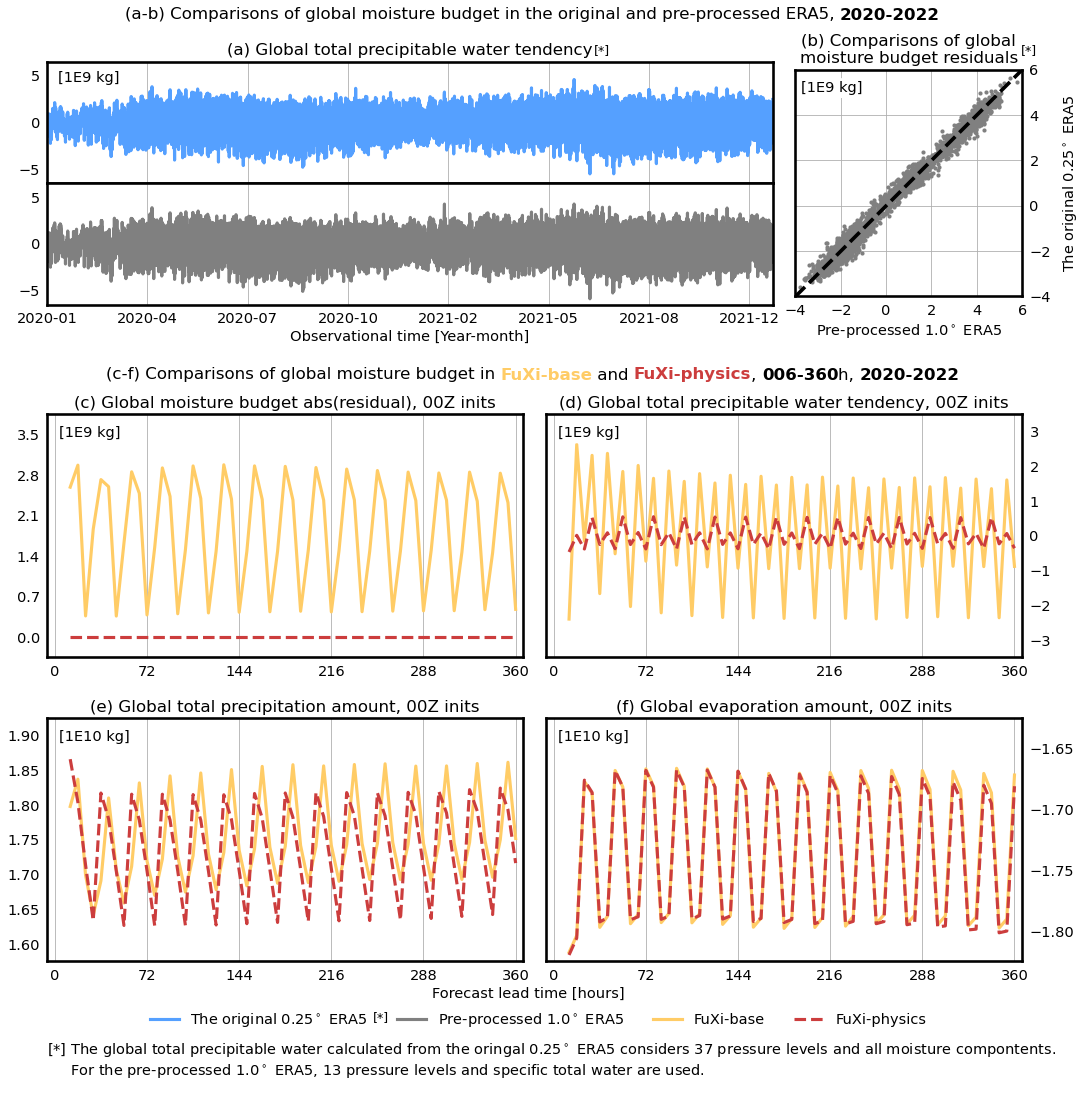

In [10]:
handles = []
L = len(DATA['ERA5_025_water_tendency'])
fake_x = np.arange(L)

fig = plt.figure(figsize=(13, 12), dpi=dpi_)
gs = gridspec.GridSpec(6, 4, height_ratios=[0.5, 0.5, 0.45, 1, 0.25, 1], width_ratios=[1, 1, 1, 1])

ax11 = plt.subplot(gs[0, :3])
ax12 = plt.subplot(gs[1, :3])
ax2 = plt.subplot(gs[:2, 3])
ax3 = plt.subplot(gs[3, :2])
ax4 = plt.subplot(gs[3, 2:4])
ax5 = plt.subplot(gs[5, :2])
ax6 = plt.subplot(gs[5, 2:4])

AX_all = [ax11, ax12, ax2, ax3, ax4, ax5, ax6]
AX_sub = [ax3, ax4, ax5, ax6]

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.1)

for ax in AX_all:
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(labelbottom=True, labelsize=14)
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.xaxis.grid(False)
    ax.grid(':', axis='x', zorder=4)
    
for ax in AX_sub:
    ax.set_xticks(LEAD_ticks)
    ax.set_xlim([LEAD_ticks[0]-6, LEAD_ticks[-1]+6])

ax11.tick_params(labelleft=True, labelsize=14)
ax11.tick_params(labelbottom=False)
ax12.tick_params(labelleft=True, labelsize=14)
ax3.tick_params(labelleft=True, labelsize=14)
ax5.tick_params(labelleft=True, labelsize=14)
ax2.tick_params(labelright=True, labelsize=14)
ax4.tick_params(labelright=True, labelsize=14)
ax6.tick_params(labelright=True, labelsize=14)
ax2.grid(':', zorder=4)


# ===================================================================== #
# ax1
ax11.plot(fake_x, 1e-9*DATA['ERA5_025_water_tendency'], **line_keys['ERA5_025'])
ax12.plot(fake_x, 1e-9*DATA['ERA5_1deg_water_tendency'], **line_keys['ERA5_1deg'])

ax11.text(0.015, 0.925, '[1E9 kg]', 
         ha='left', va='top', fontsize=14, transform=ax11.transAxes,
         bbox=dict(facecolor='w', alpha=1.0, edgecolor='none', boxstyle='round,pad=0.2')
        )

ax11.set_ylim([-6.5, 6.5])
ax12.set_ylim([-6.5, 6.5])
ax11.set_xlim([fake_x[0], fake_x[-1]])
ax12.set_xlim([fake_x[0], fake_x[-1]])
ax11.set_xticks(fake_x[::400])
ax12.set_xticks(fake_x[::400])
ax12.set_xticklabels(xticklabels[::400])
ax12.set_xlabel('Observational time [Year-month]', fontsize=14)
ax11.set_title('(a) Global total precipitable water tendency', fontsize=16)

# ===================================================================== #
# ax2
ax2.plot(
    1e-9*DATA['ERA5_1deg_water_residual'], 
    1e-9*DATA['ERA5_025_water_residual'], 
    'ko', ms=4, mec='k', mew=0, mfc='0.5')

ax2.set_aspect('equal', adjustable='box')

ax2.text(0.025, 0.95, '[1E9 kg]', 
         ha='left', va='top', fontsize=14, transform=ax2.transAxes,
         bbox=dict(facecolor='w', alpha=1.0, edgecolor='none', boxstyle='round,pad=0.2')
        )

ax2.plot([-4, 6], [-4, 6], linestyle='--', color='k', linewidth=3.5, zorder=3)
ax2.set_xlim([-4, 6])
ax2.set_ylim([-4, 6])
ax2.set_xlabel('Pre-processed 1.0$^\circ$ ERA5', fontsize=14)
ax2.yaxis.set_label_position("right") 
ax2.set_ylabel('The original 0.25$^\circ$ ERA5', fontsize=14, labelpad=10)
ax2.set_title('(b) Comparisons of global\nmoisture budget residuals', fontsize=16)

# ===================================================================== #
# ax3
ax3.set_title('(c) Global moisture budget abs(residual), 00Z inits', fontsize=16)
ax3.plot(
    LEADs, 
    np.concatenate((np.array([np.nan]), 1e-9*np.abs(DATA['fuxi_dry_water_residual']).mean(axis=0)), axis=0), 
    **line_keys['fuxi_dry'])

ax3.plot(
    LEADs, 
    np.concatenate((np.array([np.nan]), 1e-9*np.abs(DATA['fuxi_physics_water_residual']).mean(axis=0)), axis=0), 
    **line_keys['fuxi_physics'])

ax3.set_ylim([-0.35, 3.85])
ax3.set_yticks([0, 0.7, 1.4, 2.1, 2.8, 3.5])

ax3.text(0.025, 0.95, '[1E9 kg]', 
         ha='left', va='top', fontsize=14, transform=ax3.transAxes,
         bbox=dict(facecolor='w', alpha=1.0, edgecolor='none', boxstyle='round,pad=0.2')
        )

# ===================================================================== #
# ax4
ax4.set_title('(d) Global total precipitable water tendency, 00Z inits', fontsize=16)
ax4.plot(
    LEADs, 
    np.concatenate((np.array([np.nan]), 1e-9*DATA['fuxi_dry_water_tendency'].mean(axis=0)), axis=0), 
    **line_keys['fuxi_dry'])

ax4.plot(
    LEADs, 
    np.concatenate((np.array([np.nan]), 1e-9*DATA['fuxi_physics_water_tendency'].mean(axis=0)), axis=0), 
    **line_keys['fuxi_physics'])

# ref_ERA5_1deg = np.abs(DATA['ERA5_1deg_water_tendency']).mean()
# ax4.hlines(
#     y=1e-18*ref_ERA5_1deg, xmin=fake_x[0], xmax=fake_x[-1], linewidth=4, linestyle='-', color='0.5', zorder=4
# )

ax4.set_ylim([-3.5, 3.5])
ax4.set_yticks([-3, -2, -1, 0, 1, 2, 3])

ax4.text(0.025, 0.95, '[1E9 kg]', 
         ha='left', va='top', fontsize=14, transform=ax4.transAxes,
         bbox=dict(facecolor='w', alpha=1.0, edgecolor='none', boxstyle='round,pad=0.2')
        )

# ===================================================================== #
# ax5
ax5.set_title('(e) Global total precipitation amount, 00Z inits', fontsize=16)
ax5.plot(
    LEADs, 
    np.concatenate((np.array([np.nan]), 1e-10*DATA['fuxi_dry_precip'].mean(axis=0)), axis=0), 
    **line_keys['fuxi_dry'])

ax5.plot(
    LEADs, 
    np.concatenate((np.array([np.nan]), 1e-10*DATA['fuxi_physics_precip'].mean(axis=0)), axis=0), 
    **line_keys['fuxi_physics'])

ax5.set_ylim([1.575, 1.925])
ax5.set_yticks([1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9])

ax5.text(0.025, 0.95, '[1E10 kg]', 
         ha='left', va='top', fontsize=14, transform=ax5.transAxes,
         bbox=dict(facecolor='w', alpha=1.0, edgecolor='none', boxstyle='round,pad=0.2')
        )

ax5.set_xlabel('Forecast lead time [hours]', fontsize=14, x=1.01)
# ===================================================================== #
# ax6
ax6.set_title('(f) Global evaporation amount, 00Z inits', fontsize=16)
ax6.plot(
    LEADs, 
    np.concatenate((np.array([np.nan]), 1e-10*DATA['fuxi_dry_evapor'].mean(axis=0)), axis=0), 
    **line_keys['fuxi_dry'])

ax6.plot(
    LEADs, 
    np.concatenate((np.array([np.nan]), 1e-10*DATA['fuxi_physics_evapor'].mean(axis=0)), axis=0), 
    **line_keys['fuxi_physics'])

ax6.set_ylim([-1.825, -1.625])
ax6.set_yticks([-1.8, -1.75, -1.7, -1.65])

ax6.text(0.025, 0.95, '[1E10 kg]', 
         ha='left', va='top', fontsize=14, transform=ax6.transAxes,
         bbox=dict(facecolor='w', alpha=1.0, edgecolor='none', boxstyle='round,pad=0.2')
        )


# ===================================================================== #
# titles
fontsize_list = [16,]*10
fontweight_list = ['normal', 'bold']*5

ax_title0 = fig.add_axes([0.0, 1.03, 1.0, 0.03])
title_len = 0.84
handles += gu.string_partial_format(
    fig, ax_title0, 0.5*(1-title_len), 1.0, 'left', 'top', 
    [
        '(a-b) Comparisons of global moisture budget in the original and pre-processed ERA5, ',
        '2020-2022',
    ], 
    ['k', 'k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)

ax_title1 = fig.add_axes([0.0, 0.63, 1.0, 0.03])
title_len = 0.88
handles += gu.string_partial_format(
    fig, ax_title1, 0.5*(1-title_len), 1.0, 'left', 'top', 
    [
        '(c-f) Comparisons of global moisture budget in ',
        'FuXi-base',
        ' and ',
        'FuXi-physics',
        ', ',
        '006-360',
        'h, ',
        '2020-2022',
    ], 
    ['k', orange, 'k', red, 'k', 'k', 'k', 'k'], 
    fontsize_list, 
    fontweight_list
)

handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], **line_keys['ERA5_025']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['ERA5_1deg']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['fuxi_dry']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['fuxi_physics']))

ax_lg1 = fig.add_axes([0.015, -0.09, 0.9, 0.05])
#ax_lg1 = fig.add_axes([0.0, -0.235, 0.7025, 0.17])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    [
        'The original 0.25$^\circ$ ERA5',
        'Pre-processed 1.0$^\circ$ ERA5',
        'FuXi-base',
        'FuXi-physics'
    ], 
    bbox_to_anchor=(1, 1), ncol=4, prop={'size':14})

ax_s1 = fig.add_axes([0.999, 1.005, 0.015, 0.015])
ax_s1.text(0.5, 0.5, '[*]', ha='center', va='center', fontsize=12, transform=ax_s1.transAxes)

ax_s2 = fig.add_axes([0.562, 1.005, 0.015, 0.015])
ax_s2.text(0.5, 0.5, '[*]', ha='center', va='center', fontsize=12, transform=ax_s2.transAxes)

ax_s3 = fig.add_axes([0.335, -0.07, 0.015, 0.015])
ax_s3.text(0.5, 0.5, '[*]', ha='center', va='center', fontsize=12, transform=ax_s3.transAxes)

ax_w = fig.add_axes([0, -0.14, 1.0, 0.06])
ax_w.text(
    0, 0.5, 
    '[*] The global total precipitable water calculated from the oringal 0.25$^\circ$ ERA5 '
    'considers 37 pressure levels and all moisture compontents.\n'
    '     For the pre-processed 1.0$^\circ$ ERA5, 13 pressure levels and specific total water are used.', 
    ha='left', va='center', fontsize=14, transform=ax_w.transAxes);

ax_title0.set_axis_off()
ax_title1.set_axis_off()
ax_s1.set_axis_off()
ax_s2.set_axis_off()
ax_s3.set_axis_off()
ax_w.set_axis_off()
LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()